<h1><center>RESEAUX DE CONVOLUTION</center></h1>

# Introduction

Les réseaux neuronaux convolutifs (CNNs ou "ConvNets") ont connu un énorme succès, en particulier dans le domaine de la vision, bien qu'ils aient également été utilisés dans le traitement de la parole et pour la traduction automatique. Dans ce TP, nous aborderons les bases des CNNs, et entraînerons un réseau convolutif en utilisant Keras, ainsi qu'un GPU pour accélérer l'entraînement.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

# Architectures de convolution
Lorsque l'on modélise une image en utilisant un DNN régulier, on constate que le nombre de paramètres du modèle augmente de manière exponentielle. Les ConvNets abordent ce problème en exploitant la structure des entrées du réseau (en particulier, en faisant l'hypothèse que l'entrée est un *volume* en 3-D, ce qui s'applique aux images par exemple, où les 3 dimensions sont constituées des trois canaux RVB -ou RGB en anglais). Les deux principales différences entre un réseau ConvNet et un réseau dense sont :

* Les ConvNets ont des neurones qui sont disposés en 3 dimensions : largeur, hauteur, profondeur. Notez que *profondeur* signifie ici canaux, c'est-à-dire la profondeur du volume d'entrée, et non la profondeur d'un DNN !
* Les neurones de chaque couche ne sont connectés qu'à une petite région de la couche précédente.

En général, une architecture ConvNet est composée de différents types de couches, les plus courantes étant les couches convolutionnelles, les couches de regroupement et les couches entièrement connectées.

## Couches de convolution

Une couche de convolution bidimensionnelle fait correspondre un *volume* d'entrée (c'est-à-dire un tenseur d'entrée 3D, par exemple [largeur, hauteur, canaux]) à un *volume* de sortie par le biais d'un ensemble de filtres, qui constituent les paramètres de la couche. Chaque filtre est petit dans l'espace (en largeur et en hauteur), mais s'étend sur toute la profondeur du volume d'entrée. (Ex : un filtre dans la première couche d'un ConvNet peut avoir la taille [5, 5, 3]).

Pendant la passe en avant ( *forward pass* ), nous faisons "glisser" chaque filtre sur la largeur et la hauteur du volume d'entrée et calculons des produits élément par élément entre les entrées du filtre et l'entrée à n'importe quelle position. Lorsque nous faisons glisser le filtre sur la largeur et la hauteur du volume d'entrée, nous produisons une carte d'activation (*activation map*) bidimensionnelle qui stock les réponses de ce filtre à chaque position spatiale. Chaque couche convolutionnelle aura un tel ensemble de filtres, et chacun d'entre eux produira une carte d'activation bidimensionnelle séparée. Nous empilons ensuite ces cartes d'activation le long de la dimension de profondeur pour produire le volume de sortie.

En utilisant ces filtres, nous pouvons contrôler l'explosion des paramètres que nous obtiendrions avec un réseau dense. Ce **partage des paramètres** tend également à améliorer les performances du modèle sur des entrées comme les images naturelles car il fournit au modèle une **invariance de translation**. En effet, si l'image (ou un élément de l'image) est translatée (déplacée), le modèle ne sera pas affecté de manière significative.

L'animation suivante illustre ces idées, assurez-vous de bien les comprendre !

![Couche de convolution](https://raw.githubusercontent.com/aissam-out/cours-DL/master/images/conv3.gif)

Si l'aspect du partage des paramètres des CNNs n'est toujours pas clair, considérez le diagramme suivant qui compare une couche convolutionnelle 1-D simplifiée avec une couche entièrement connectée. Le diagramme montre comment une entrée 1-D $\mathbf{x}$ est mappée à une sortie 1-D $\mathbf{y}$ en utilisant à la fois une couche entièrement connectée et une couche convolutionnelle (sans biais). Les couleurs des bords représentent la valeur des paramètres de poids dans les couches. Pour la couche entièrement connectée, le nombre de poids est le produit des tailles d'entrée et de sortie, dans ce cas, $6 \times 4 = 24$. D'autre part, le nombre de poids dans la couche convolutionnelle dépend uniquement de la taille du filtre de la convolution, dans ce cas, $3$, et est indépendant des tailles d'entrée et de sortie.

![Partage des poids](https://raw.githubusercontent.com/aissam-out/cours-DL/master/images/dnnVSconv.png)


Les hyperparamètres d'une couche convolutive sont les suivants :
* **Filtres :** définit le nombre de filtres dans la couche
* **Taille du noyau - Kernel Size :** définit la largeur et la hauteur des filtres (aussi appelés "noyaux") dans la couche. Notez que les noyaux ont toujours la même profondeur que les entrées de la couche.
* **Stride** définit le nombre de pixels par lequel nous déplaçons le filtre lorsque nous le "glissons" le long du volume d'entrée. En général, cette valeur est de 1, mais des valeurs de 2 et 3 sont parfois aussi utilisées.
* **Padding** désigne l'ajout de pixels de valeur 0 aux bords du volume d'entrée le long des dimensions largeur et hauteur. Dans Tensorflow, vous pouvez régler cette valeur sur "VALID", qui ne fait essentiellement pas de padding, ou sur "SAME" qui va permettre à la largeur et la hauteur de la sortie d'être identiques à celles de l'entrée.



## Construire des filtres complexes

L'une des raisons du succès des CNN est leur capacité à construire des filtres complexes en composant des filtres plus simples. Par exemple, imaginez un CNN à 5 couches qui a été formé pour détecter les visages. Les 4 premières couches sont convolutives et la dernière couche est entièrement connectée et produit la prédiction finale (y a-t-il un visage ou non). Nous pourrions constater que les filtres de chaque couche convolutionnelle retiennent les caractéristiques suivantes :

1. les lignes (horizontales, verticales, diagonales), et les gradients de couleur,
2. les coins, les cercles et autres formes simples, et les textures simples,
3. le nez, la bouche et les yeux,
4. des visages entiers.

Le réseau neuronal a appris à repérer les objets complexes comme les traits du visage et même les visages entiers ! La raison en est que chaque couche successive peut combiner les filtres de la couche précédente pour détecter des caractéristiques de plus en plus sophistiquées. Le diagramme suivant (adapté de [cet article](http://web.eecs.umich.edu/~honglak/icml09-ConvolutionalDeepBeliefNetworks.pdf)) montre quelques exemples très intéressants de ce type de comportement. Les caractéristiques de niveau inférieur (illustrées ci-dessous) détectent le nez, les yeux et la bouche, dans le cas des visages; et les roues, les portes et les fenêtres, dans le cas des voitures. Les fonctions de niveau supérieur sont ensuite capables de détecter des visages et des voitures entiers.

![Aggrégation](https://raw.githubusercontent.com/aissam-out/cours-DL/master/images/conv4.jpg)

Les diagrammes de la page 7 de [cet article classique](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) montrent d'autres exemples de ce phénomène et valent certainement la peine d'être consultés !

# (Max) Pooling

Une couche de regroupement (*pooling*) réduit la taille spatiale de la représentation. Il y a différentes raisons pour lesquelles nous pouvons vouloir faire cela. La première est de réduire le nombre de paramètres dans le réseau. Imaginez un ConvNet pour attaquer MNIST. Si le tenseur de caractéristiques produit par la couche finale conv+pool+relu était, par exemple, de taille 20x20 et disposait de 100 canaux de caractéristiques, la couche dense finale aurait des paramètres 20x20x100x10=400K. Cependant, si nous réduisons cette couche à une taille de 4x4, nous n'aurions que 20K paramètres. Une grande différence !

Une autre raison est que nous voulons que les fonctionnalités ultérieures (plus profondes dans le réseau) aient des *champs récepteurs* (régions d'entrée qu'ils surveillent) plus grands, afin de représenter des objets et des parties d'objets plus grands par exemple.

Une couche de regroupement n'a pas de paramètres pouvant être entraînés. Elle applique une opération d'agrégation 2D (généralement un max(), mais d'autres comme average() peuvent également être utilisés) à des régions du volume d'entrée. Cette opération est effectuée indépendamment pour chaque dimension de profondeur de l'entrée. Par exemple, une opération d'agrégation 2x2 max avec stride=2, réduit chaque tranche de profondeur de l'entrée par 2 le long de la largeur et de la hauteur.

Les hyper-paramètres d'une couche de regroupement sont les suivants :
* **Pool Size** définit combien de valeurs sont agrégées.
* **Stride** définit le nombre de pixels par lequel nous déplaçons le filtre de regroupement lorsque nous le faisons glisser le long de l'entrée. En général, cette valeur est égale au *Pool Size*.
* **Padding** fait référence à l'ajout de pixels de valeur 0 aux bords du volume d'entrée le long des dimensions de largeur et de hauteur.


## Champs de réception (receptive fields)

Nous avons mentionné que l'une des raisons de procéder à un regroupement est d'augmenter la taille des champs de réception de nos caractéristiques. Voyons de plus près ce que nous entendions par cela.

Le diagramme ci-dessous montre le champ de réception effectif d'un "neurone" de sortie dans chaque couche de quelques réseaux simples. Le diagramme nous indique combien de valeurs d'entrée ont un effet sur chaque valeur de sortie.

Nous pouvons voir que dans les deux premiers exemples, avec des couches convolutionnelles simples, le champ réceptif est simplement égal à la taille du noyau.

Cependant, les deux exemples d'après sont un peu plus intéressants. Ici, nous avons considérablement augmenté la taille du champ de réception, sans augmentation importante du nombre de paramètres, en empilant les couches de convolution et de regroupement. Ce qui est intéressant ici, c'est qu'en utilisant une couche de regroupement, nous avons augmenté la taille de notre champ de réception à un coût beaucoup plus faible (en nombre de paramètres) que si nous avions simplement augmenté la taille des noyaux de nos couches de convolution.



![Champs de réception](https://raw.githubusercontent.com/aissam-out/cours-DL/master/images/recFields.png)



## CIFAR10 Dataset

Maintenant que nous comprenons les couches convolutionnelles, max-pooling et DNNs, nous pouvons les combiner comme des blocs pour construire un classificateur ConvNet pour les images. Pour cela, nous utiliserons l'ensemble de données d'images en couleur CIFAR10 qui comprend 50 000 images d'entraînement et 10 000 images de test.

In [ ]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [ ]:
# Prendre les 10000 dernières images d'entraînement pour former un ensemble de validation
train_labels = train_labels.squeeze()
validation_images = train_images[-10000:, :, :]
validation_labels = train_labels[-10000:]
train_images = train_images[:-10000, :, :]
train_labels = train_labels[:-10000]

Quelles sont les tailles et les types de données des images d'entraînement et de leurs labels ?

In [ ]:
print('train_images.shape = {}, data-type = {}'.format(train_images.shape, train_images.dtype))
print('train_labels.shape = {}, data-type = {}'.format(train_labels.shape, train_labels.dtype))

print('validation_images.shape = {}, data-type = {}'.format(validation_images.shape, validation_images.dtype))
print('validation_labels.shape = {}, data-type = {}'.format(validation_labels.shape, validation_labels.dtype))

train_images.shape = (40000, 32, 32, 3), data-type = uint8
train_labels.shape = (40000,), data-type = uint8
validation_images.shape = (10000, 32, 32, 3), data-type = uint8
validation_labels.shape = (10000,), data-type = uint8


## Visualiser des exemples tirés de l'ensemble de données
Executez la cellule ci-dessous plusieurs fois pour voir les différentes images. (Elles peuvent sembler un peu floues car les petites images ont été agrandies).

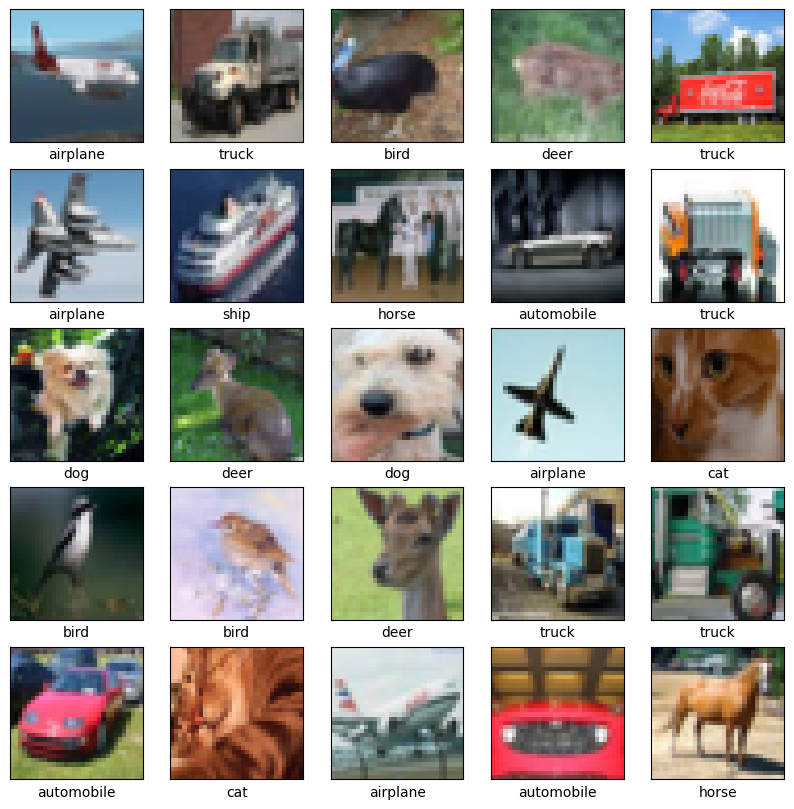

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  img_index = np.random.randint(0, 40000)
  plt.imshow(train_images[img_index])
  plt.xlabel(cifar_labels[train_labels[img_index]])

## Un classificateur ConvNet
Enfin, nous construisons une architecture convolutionnelle simple pour classer les images CIFAR. Nous allons construire une mini version de l'architecture AlexNet, qui consiste en 5 couches convolutives avec un max pooling, suivies de 3 couches entièrement connectées à la fin. Pour étudier l'effet de chacune de ces deux blocs sur le nombre de paramètres, nous construirons le modèle en deux étapes.

Tout d'abord, les couches convolutionnelles + max-pooling :

In [ ]:
# Définir la partie convolutionnelle du modèle en utilisant les couches de Keras.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Combien de paramètres y a-t-il dans la partie convolutive de l'architecture ?

Nous pouvons facilement l'inspecter en utilisant la fonction *summary* dans Keras :

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 48)          │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 10, 10, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 128)         │          55,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 192)           │         221,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 192)           │         331,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 3, 3, 128)           │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 831,424 (3.17 MB)

 Trainable params: 831,424 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

Nous ajoutons maintenant une partie entièrement connectée. Notez que nous ajoutons également "Dropout" après la première couche entièrement connectée. Le dropout est une technique de régularisation qui enlève ("drop") les connexions entre les neurones de manière aléatoire.

In [ ]:
model.add(tf.keras.layers.Flatten())  # Aplatir un volume 3D en un seul vecteur.
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 48)          │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 10, 10, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 128)         │          55,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 192)           │         221,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 192)           │         331,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 3, 3, 128)           │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,023,370 (7.72 MB)

 Trainable params: 2,023,370 (7.72 MB)

 Non-trainable params: 0 (0.00 B)

## Lecture supplémentaire facultative : Schémas d'initialisation aléatoires

Vous vous êtes peut-être demandé quelles valeurs nous utilisons pour les valeurs initiales des poids et des biais de notre modèle. La réponse courte est que nous utilisons généralement l'initialisation aléatoire. Dans ce cas, nous avons juste utilisé les initialisateurs Keras par défaut pour chaque couche, qui sont généralement suffisants.

La réponse plus longue est que l'utilisation de nombres complètement aléatoires ne fonctionne pas toujours de manière optimale dans la pratique et qu'il existe un certain nombre de schémas d'initialisation communs (qui sont disponibles dans la plupart des frameworks d'apprentissage profond tels que TensorFlow et Keras).

Examinons quelques exemples :

 * Lorsque l'on utilise l'activation ReLU, il est courant d'initialiser les biais avec de petits nombres positifs car cela encourage les activations ReLU à démarrer dans l'état _on_, ce qui permet de contrer le problème _dying ReLU_.

 * Plus les réseaux neuronaux sont profonds, plus il est probable que les gradients se rétrécissent au point de disparaître ou qu'ils se développent au point de déborder (problèmes de disparition et explosion des gradients). Pour lutter contre ce phénomène, nous pouvons initialiser nos poids afin de disposer d'une échelle appropriée (spécifique au modèle). Une méthode pour ce faire est appelée initialisation [Xavier ou Glorot](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).

 * Le schéma d'initialisation _Xavier_ a été conçu en tenant compte des activations _traditionnelles_ Sigmoid et TanH et ne fonctionne pas aussi bien pour les activations ReLU. Une alternative est l'initialisation [He ou Kaiming](https://arxiv.org/pdf/1502.01852.pdf) qui est une modification de l'initialisation de Xavier pour les activations ReLU.

[La documentation Keras](https://keras.io/initializers/) énumère un certain nombre de schémas courants.

## Visualiser le modèle

Construisons un diagramme de flux du modèle que nous avons crée pour voir comment l'information circule entre les différentes couches.

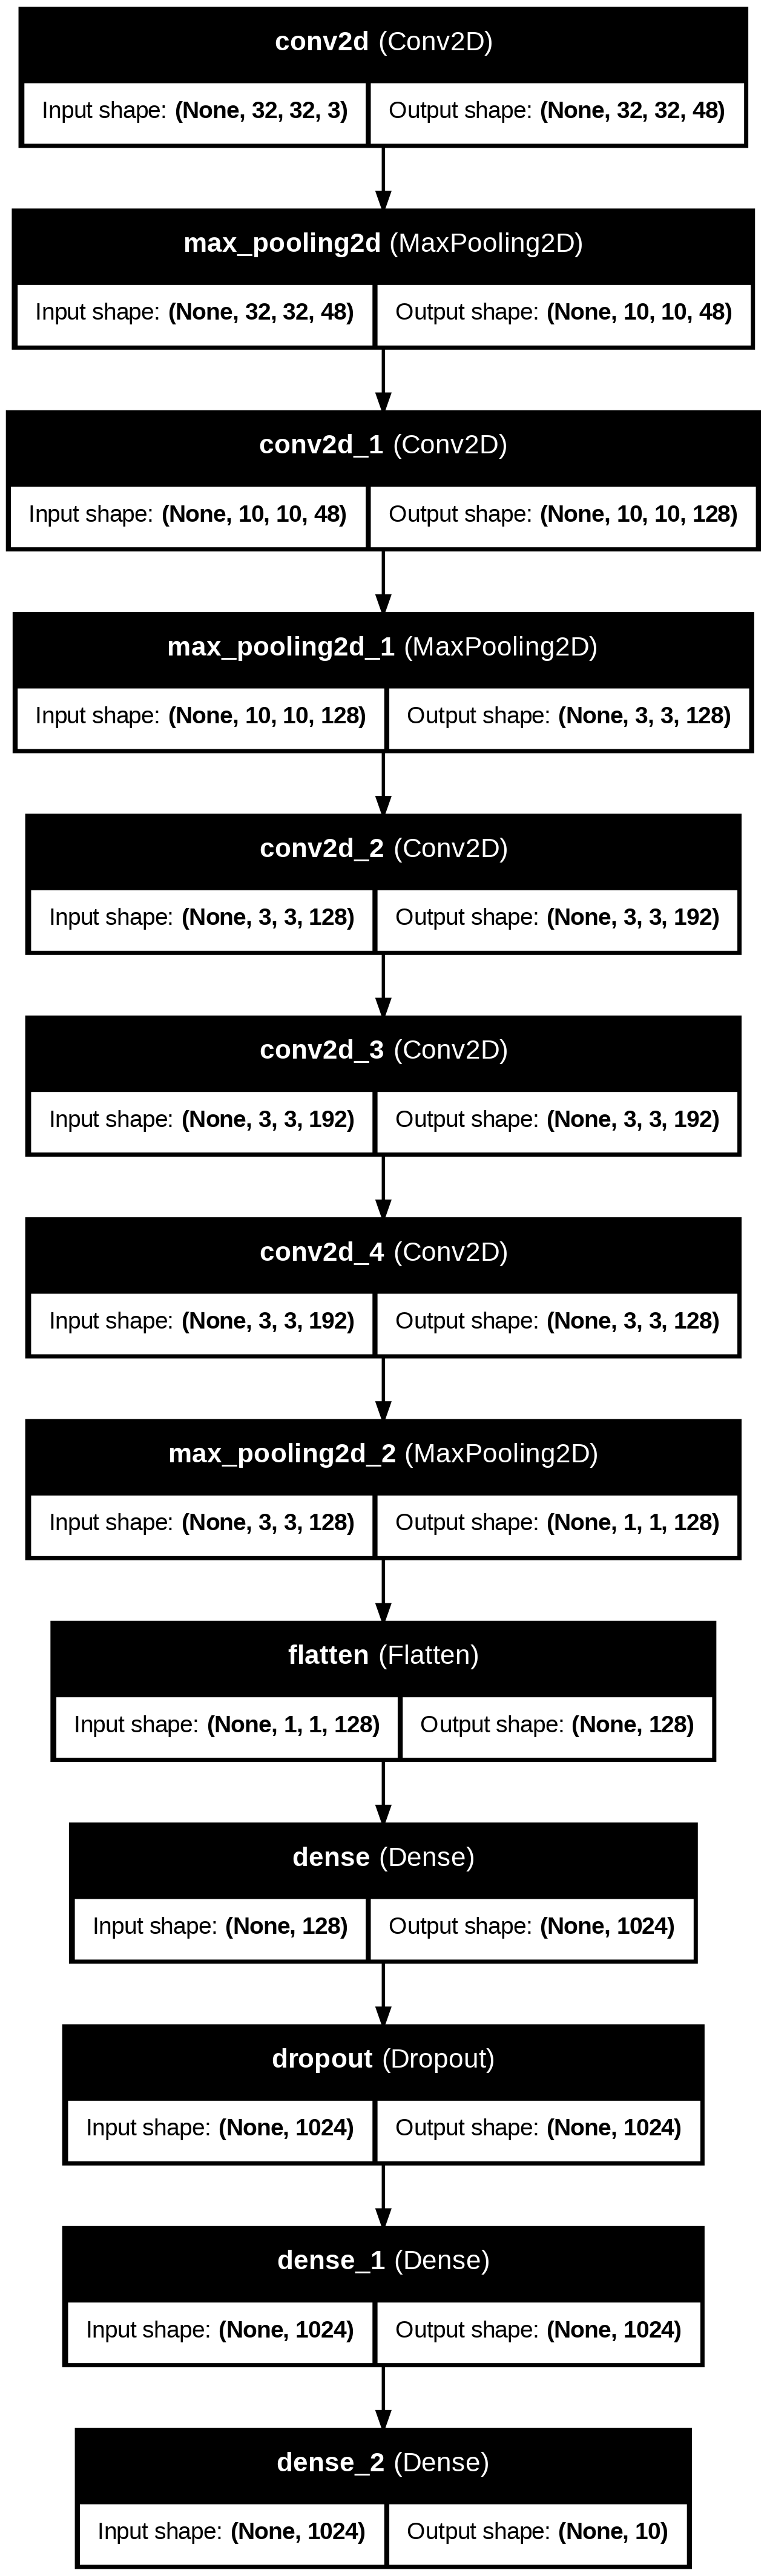

In [ ]:
tf.keras.utils.plot_model(model, to_file='small_lenet.png', show_shapes=True, show_layer_names=True)
display.display(display.Image('small_lenet.png'))


## Enraînement et validation du modèle
Ici nous allons utiliser la boucle d'entraînement intégrée à Keras. Pour des ensembles de données simples et standard comme le CIFAR, cette méthode fonctionnera bien, mais il est important de savoir ce qui se passe sous le capot car vous devrez peut-être écrire manuellement certaines ou toutes les étapes lorsque vous travaillerez avec des données plus complexes !

In [ ]:
batch_size = 128
num_epochs = 10  # Le nombre d'époques pour lesquelles il faut s'entraîner

# La compilation du modèle ajoute une fonction de perte, un optimiseur et des métriques à suivre pendant l'entraînement
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# La fonction "fit" permet d'adapter le modèle compilé aux données d'entraînement
model.fit(x=train_images,
          y=train_labels,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 439ms/step - accuracy: 0.2759 - loss: 2.2046 - val_accuracy: 0.5274 - val_loss: 1.3326
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 434ms/step - accuracy: 0.5434 - loss: 1.2894 - val_accuracy: 0.5518 - val_loss: 1.2384
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 446ms/step - accuracy: 0.6088 - loss: 1.1111 - val_accuracy: 0.6322 - val_loss: 1.0772
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 450ms/step - accuracy: 0.6567 - loss: 0.9841 - val_accuracy: 0.6063 - val_loss: 1.1050
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 444ms/step - accuracy: 0.6941 - loss: 0.8821 - val_accuracy: 0.6475 - val_loss: 1.0123
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 428ms/step - accuracy: 0.7222 - loss: 0.8000 - val_accuracy: 0.6522 - val_loss: 1.0187
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 422ms/step - accuracy: 0.7489 - loss: 0.7200 - val_accuracy: 0.6716 - val_loss: 0.9975
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 423ms/step - accuracy: 0.7694 -

## Test des performances  
Enfin, nous évaluons les résultats du modèle sur l'ensemble des tests effectués

In [ ]:
metric_values = model.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6814 - loss: 1.0348
Final TEST performance
loss: 1.052446961402893
compile_metrics: 0.6800000071525574


Notez que nous avons atteint une précision d'environ 80 % pour les ensembles d'entraînement, mais que la précision de nos tests n'est que de 67 % environ. Selon vous, quelle en est la raison ?

## Classification des exemples
Nous utilisons maintenant notre modèle entraîné pour classer un échantillon de 25 images de l'ensemble de test. Nous passons ces 25 images à la fonction ```model.predict```, qui renvoie une matrice dimensionnelle [25, 10]. La valeur dans la position $(i, j)$ de cette matrice contient la probabilité que l'image $i$ appartienne à la classe $j$. Nous obtenons la prédiction la plus probable en utilisant la fonction ```np.argmax``` qui renvoie l'indice de l'entrée maximale le long des colonnes. Enfin, nous traçons le résultat avec la prédiction et la probabilité de prédiction étiquetées sous l'image et le label vrai sur le côté.

In [ ]:
img_indices = np.random.randint(0, len(test_images), size=[25])
sample_test_images = test_images[img_indices]
sample_test_labels = [cifar_labels[i] for i in test_labels[img_indices].squeeze()]

predictions = model.predict(sample_test_images)
max_prediction = np.argmax(predictions, axis=1)
prediction_probs = np.max(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


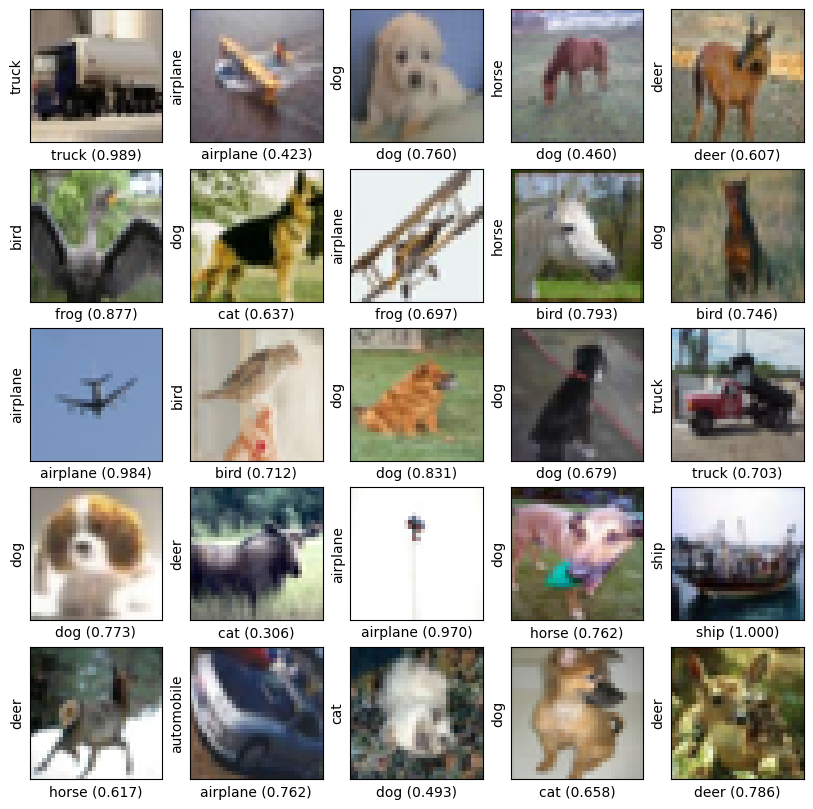

In [ ]:
plt.figure(figsize=(10,10))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  plt.imshow(img)
  plt.xlabel('{} ({:0.3f})'.format(cifar_labels[prediction], prob))
  plt.ylabel('{}'.format(true_label))


# Lecture supplémentaire facultative : L'incertitude dans l'apprentissage profond

Les réseaux neuronaux profonds ne sont pas très bons pour estimer l'incertitude de leurs prédictions. Cependant, connaître l'incertitude de votre modèle peut être très important pour de nombreuses applications. Par exemple, considérez un outil d'apprentissage profond pour diagnostiquer des maladies. Dans ce cas, un faux négatif pourrait avoir des impacts massifs sur la vie d'une personne ! Nous aimerions vraiment savoir à quel point notre modèle est confiant dans ses prédictions.